# Assignment 3 (100 marks)

## *Generating useful features for further analysis on Amazon reviews*

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats 
from pingouin import pairwise_tests #this is for performing the pairwise tests
from pingouin import pairwise_ttests #this is for performing the pairwise tests
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import gzip
import json
import string
import nltk # imports the natural language toolkit
import plotly
import collections
from nltk.corpus import stopwords
%matplotlib inline
nltk.download('punkt')

# We won't use this one this time
# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
# instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("Movies_and_TV_5.json", lines=True, chunksize=100000))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nehem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: total: 1.95 s
Wall time: 8.26 s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [3]:
print(len(movies_tv))
print(movies_tv.head(5))

100000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      1

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [4]:
movies_tv.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [5]:
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")

In [6]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


### Exercise 1 (22 marks): 

#### 1.1 (4 marks)

Plot histograms of all numeric quantities for the `movies_tv` DataFrame. Note any observations (a few bullet points is fine). 

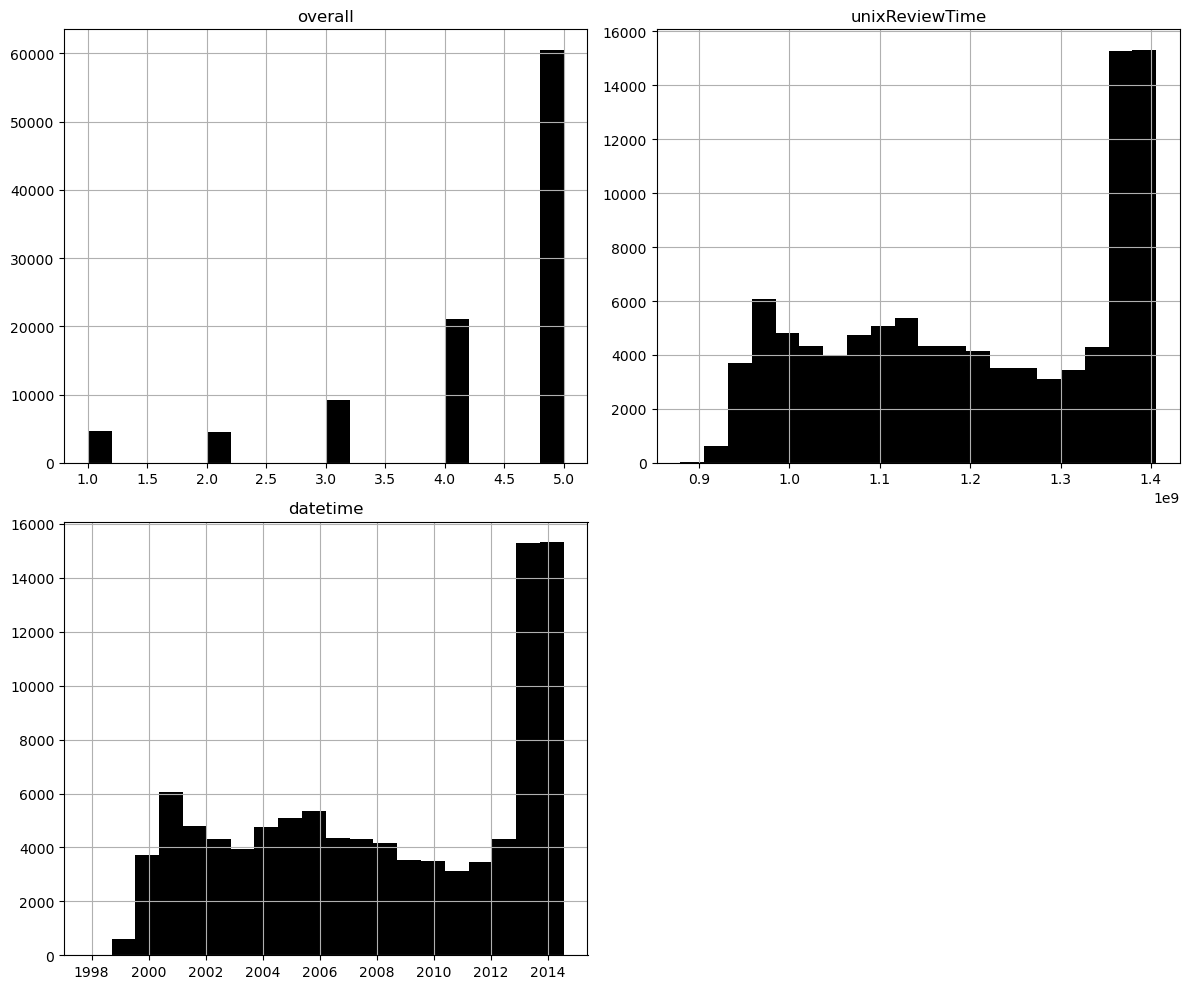

In [7]:
movies_tv.hist(figsize=(12,10), bins=20,color="black")
plt.tight_layout()
plt.show()

Simple and succinct results that I was able to extract from the graphs:

 - The majority of reviews on the Amazon website are from 2014, it grew more than four fold from 2012.
 - The vast majority of overall ratings in Amazon are 5. People love their products.
 - While the overall's graph has a consistent growth, datatime/unixReview have more volatile graph but eventually grow positively.

#### 1.2 (4 marks)

How do average ratings change over time in the `movies_tv` DataFrame? Plot the average rating for each year and note any trends (a few bullet points is fine). 

In [8]:
movies_tv['year'] = pd.to_datetime(movies_tv['unixReviewTime'], unit='s').dt.year
average_rating_by_year = movies_tv.groupby('year')['overall'].mean()

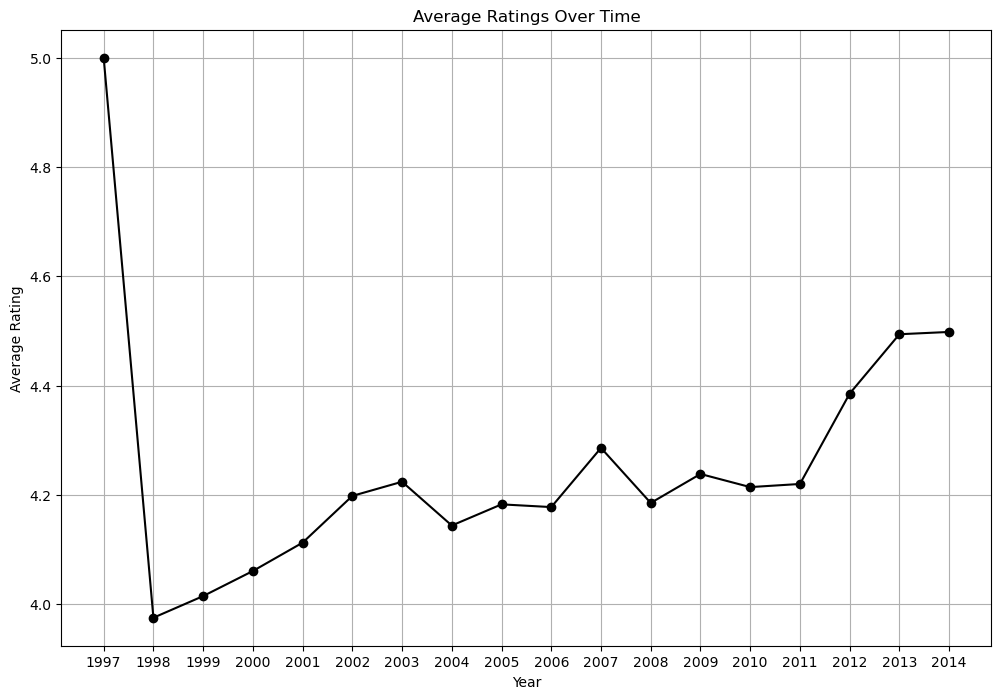

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(average_rating_by_year.index, average_rating_by_year.values, marker='o', linestyle='-', color='black')
plt.title('Average Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.xticks(list(map(int, average_rating_by_year.index)))
plt.show()


* Movies had insanely high ratings in the 90's and they greatly collapsed before picking up late 2000's and growing more again in the early 2010's. 
* The average ratings may have been high in the 90's and became lower afterwards, but the ratings always stayed positive.
* 1997 was the highest year for ratings, 1998 is the lowest year for ratings.

**Answer.** 

#### 1.3 (4 marks)

Plot the average length of the reviews in the `movies_tv` DataFrame for each year. Note any trends (a few bullet points is fine). 

In [10]:
movies_tv['year'] = movies_tv['datetime'].dt.year
movies_tv['reviewLength'] = movies_tv['reviewText'].apply(len)

In [11]:
average_length_by_year = movies_tv.groupby('year')['reviewLength'].mean()

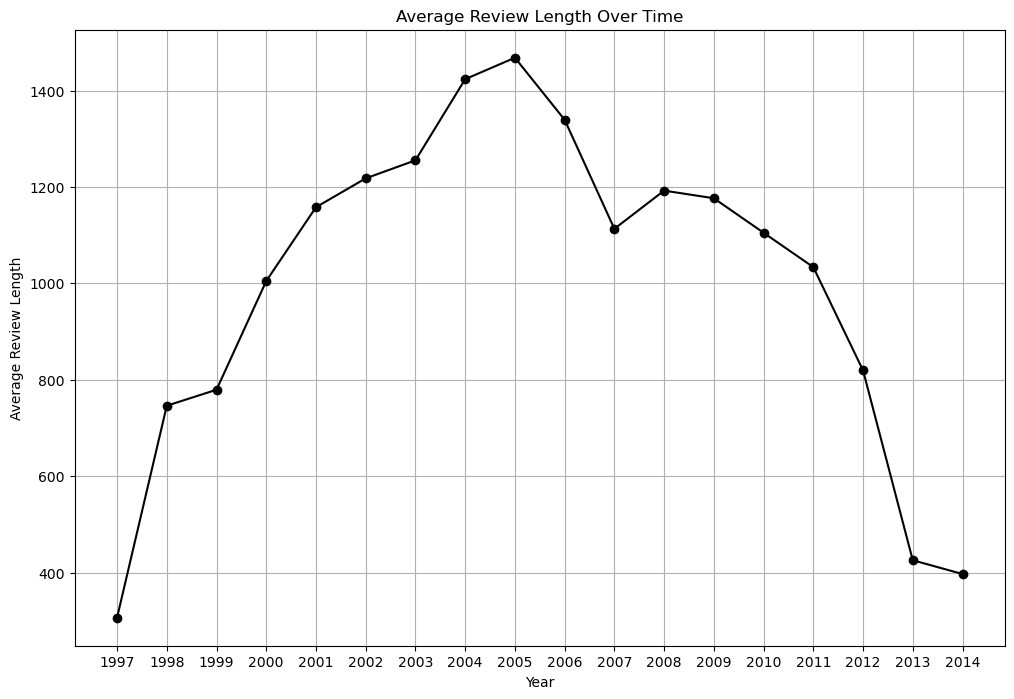

In [12]:
plt.figure(figsize=(12,8))
plt.plot(average_length_by_year.index, average_length_by_year.values, marker='o', linestyle='-', color='black')
plt.title('Average Review Length Over Time')
plt.xlabel('Year')
plt.ylabel('Average Review Length')
plt.grid(True)
plt.xticks(list(map(int, average_length_by_year.index)))
plt.show()

* One correlation I made while viewing this graph is that on years where the ratings are extremely high, the review length is significantly shorter  as 1997 and 2014 have the lowest review length, while their ratings is extremely high. Although this is true for many cases, it is false for some.
* People in 2005 wrote the longest reviews.
* The graph follows a negative square graph trajectory.
* Following point three; the review length grows upto 2005, and then declines upto 2014. 

#### 1.4 (10 marks)

We saw that movies and TV seem to have higher ratings in the 90s. Use a hypothesis test to determine if this is a statistically significant pattern. Specifically, 
- State the null and alternative hypotheses
- Run the appropriate hypothesis test in python
- Use the output to decide if you reject or fail to reject the null hypothesis 
- Interpret the p-value in this context 

In [13]:
movies_tv['year'] = pd.to_datetime(movies_tv['unixReviewTime'], unit='s').dt.year

ratings_90s = movies_tv[(movies_tv['year'] >= 1990) & (movies_tv['year'] <= 1999) | ((movies_tv['year'] >= 2000) & (movies_tv['year'] <= 2009))]['overall']

t_stat, p_value = stats.ttest_1samp(ratings_90s, ratings_90s.mean())

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis")


Failed to reject the null hypothesis


**Answer.** 

### Exercise 2 (10 marks): 

For the remainder of the assignment, we will use a smaller version of the `movies_tv` DataFrame given below:

In [14]:
short_movies_tv = movies_tv.head(10000)

Find the ten most frequently occurring non-stop words across: (i) all reviews, (ii) positive reviews (higher than 3 stars), (iii) (lower than 3 stars) negative reviews. 
Make a bar plot of the ten most frequently occurring words against their frequencies for each category ((i) (ii) and (iii)). What do you notice when comparing the graphs? Do the results surprise you? Why or why not? (A few bullet points is fine)

In [15]:
from collections import Counter
def plot_word_frequencies(reviews, title):
    all_reviews = " ".join(reviews)
    stop_words = set(stopwords.words("english"))
    words = [word.lower() for word in all_reviews.split() if word.isalpha() and word.lower() not in stop_words]
    word_counts = Counter(words)
    top_words = dict(word_counts.most_common(10))
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), color='black')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

In [16]:
positive_reviews = movies_tv[movies_tv['overall'] > 3]['reviewText']
negative_reviews = movies_tv[movies_tv['overall'] < 3]['reviewText']

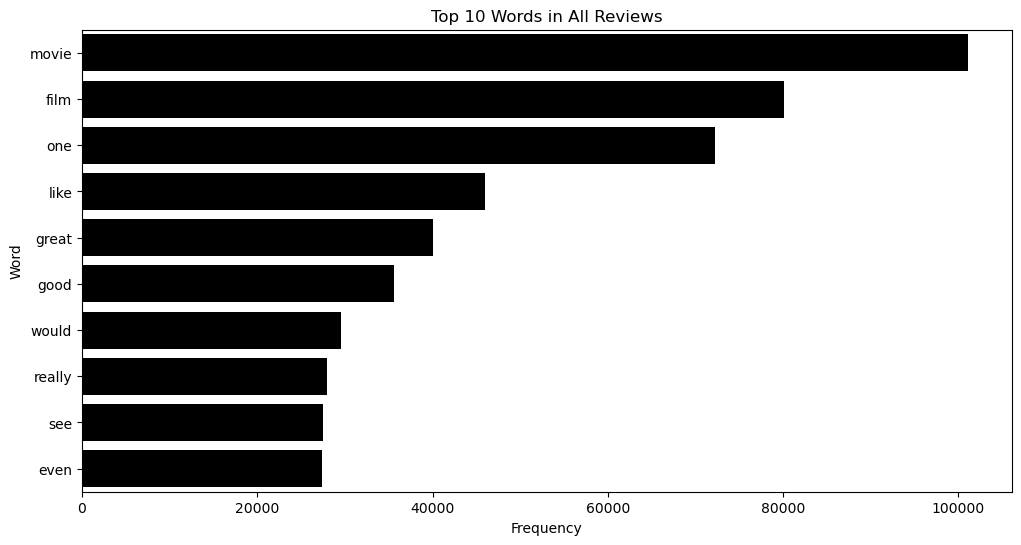

In [17]:
plot_word_frequencies(movies_tv['reviewText'], 'Top 10 Words in All Reviews')

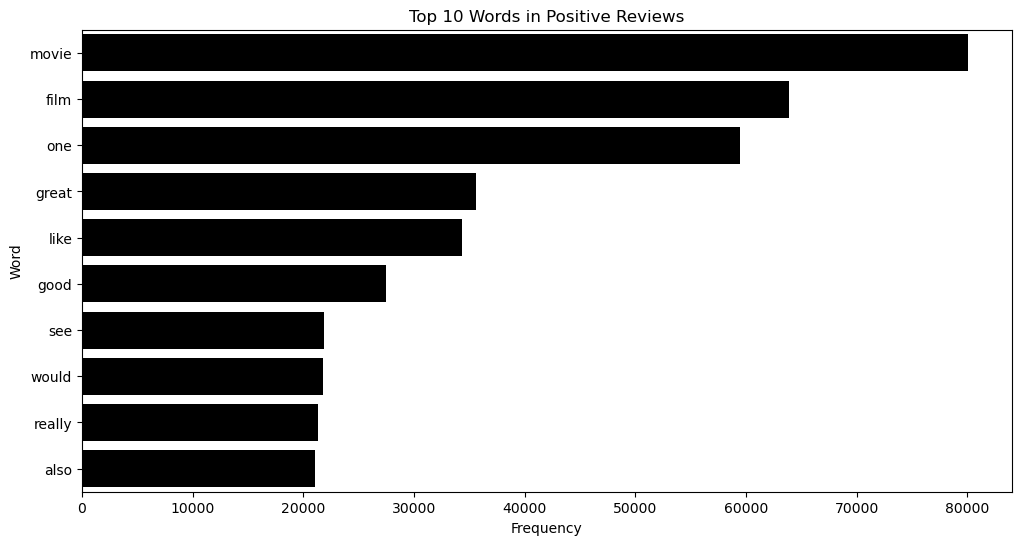

In [18]:
plot_word_frequencies(positive_reviews, 'Top 10 Words in Positive Reviews')

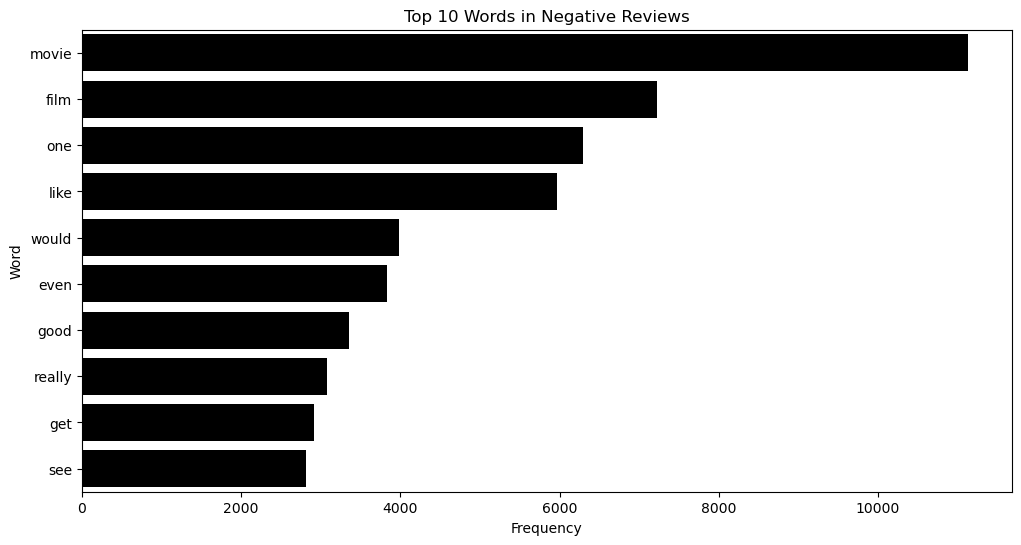

In [19]:
plot_word_frequencies(negative_reviews, 'Top 10 Words in Negative Reviews')

All the graphs have "movie", "film", "one" are constants in Top 10 words, Top 10 words in positve reviews, and Top 10 words in negative reviews. This is no suprise as you use these words regardless of the review's points. "This movie is....", "One thing about the film", etc. Also the other words are in a way similar too, but they are on a different ranking. This means that the reviews all have common sentencing that is the norm to leaving reviews.

### Exercise 3 (8 marks):

Find 20 words that are indicative of bad reviews. That is, come up with a method to identify words that appear frequently in the bad reviews but do *not* occur frequently in the good reviews. What are these words? What do you observe about these words? Are they surprising?

In [20]:
all_reviews = movies_tv['reviewText']
good_reviews = movies_tv[movies_tv['overall'] > 3]['reviewText']
bad_reviews = movies_tv[movies_tv['overall'] < 3]['reviewText']

In [21]:
stop_words = set(stopwords.words("english"))
all_words = [word.lower() for review in all_reviews for word in review.split() if word.isalpha() and word.lower() not in stop_words]
good_words = [word.lower() for review in good_reviews for word in review.split() if word.isalpha() and word.lower() not in stop_words]
bad_words = [word.lower() for review in bad_reviews for word in review.split() if word.isalpha() and word.lower() not in stop_words]



In [22]:
all_word_counts = collections.Counter(all_words)
good_word_counts = collections.Counter(good_words)
bad_word_counts = collections.Counter(bad_words)

In [23]:
word_freq_diff = {word: bad_word_counts[word] - good_word_counts[word] for word in bad_word_counts}

In [24]:
sorted_diff = sorted(word_freq_diff.items(), key=lambda x: x[1], reverse=True)

In [25]:
top_20_bad_words = [word for word, _ in sorted_diff[:20]]
print("Top 20 Words Indicative of Bad Reviews:")
print(top_20_bad_words)

Top 20 Words Indicative of Bad Reviews:
['waste', 'worst', 'redeeming', 'poorly', 'overrated', 'shao', 'uninteresting', 'stinker', 'unfunny', 'unconvincing', 'travesty', 'rasheed', 'pointless', 'raiden', 'charlize', 'rhinoceros', 'miserably', 'insipid', 'emmerich', 'rochester']


Analyzing the top 20 words commonly found in negative reviews has expected and straightforwardly negative descriptors like "waste," "worst," and "poorly." Yet, what adds complexity are detailed and unique elements, including specific names like "shao" and the term "travesty." These words provide a more intricate picture of viewer dissatisfaction that can be tied to a movie [shows that the movie was so bad lots of people picked up on it and is up there with commonly used negative words] , offering creators insight into not just common pain points but also unique, specifc aspects that demand attention. It's a valuable peek into the many facets contributing to viewers' discontent, guiding creators toward more precise and targeted improvements.

**Answer.**

### Exercise 4 (8 marks): 

Use the following code to inspect the first 50 1-star reviews from the `movies_tv` DataFrame containing the word "good". Discuss the most common ways the word good is used in these reviews. Are any of these informative or challenging for our analysis of what drives very negative reviews? 

In [26]:
v_bad_indices = movies_tv['overall'] < 1.1
v_bad_reviews = movies_tv[v_bad_indices]

RED_START = "\033[91m"
END = "\033[0m"

good_word_bad_review = [rev for rev in v_bad_reviews['reviewText'] if 'good' in rev.lower()]

print(len(good_word_bad_review))
for rev in good_word_bad_review[:50]:
    good_i = rev.lower().index("good")
    print(rev[good_i-50: good_i] + RED_START + rev[good_i:good_i+4] + END + rev[good_i+4:good_i +50])

1266
good, the story was correct, but naked backsides w
good but the scene with Yukon discovering peppermi
th absolutely NO edits whatsoever to the material.Good for us!Edits are for losers!I have spoken.
t least made it about an interesting story with a good plot and character development...i agree with
t everything I've seen thus far does not resemble good cinema in any shape, form, or manner. So, I g
itself is beautifully filmed. The acting is quite good and as a history freak I found it interesting
rtaining) and provides nothing that makes us feel good or is uplifting or is of any benefit, except 
ven if that person is Christ. The flashbacks were good and I'd rather have watched them than watched
to explain what singled out Christ as a symbol of good because a)he is a shallow and poor filmmaker 
 (and no-one could endure the pain).They say it's good to show the extent of the sacrifice that Jesu
good review when it was released, and I went to se
 story that everyone knows and of cor

**Answer.**

## Analyzing 1-star reviews mentioning "good" sheds light on common complaints. Viewers often feel let down when a movie starts well but takes a confusing turn, emphasizing the need for a clear plot. For example, some reviewers were disappointed by a film's promising start turning into a confusing storyline. Others express frustration that even good elements like acting or visuals don't compensate for weak plots. One review, for instance, noted good cinematography but criticized the lackluster story. Viewers also desire realism and consistency, as seen in a review finding dubbing bothersome, can sour the overall impression. Notably, these negative uses of "good" align with our previous understanding from question two that "good" is commonly used in negative reviews, it just shows us how the word good is used in negative reviews.

### Exercise 5 (15 marks): 

For each review in the list of bad reviews containing the word "good" that we found in the last question (`good_word_bad_review`) extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

For example, "The popcorn at the movie was very good with butter." would have the solution

1. with
2. butter
3. movie

Print out the results for the first 15 reviews in the list `good_word_bad_review`. 

**Answer.** 

In [27]:
v_bad_indices = movies_tv['overall'] < 3
v_bad_reviews = movies_tv[v_bad_indices]

In [28]:
RED_START = "\033[91m"
END = "\033[0m"

good_word_bad_review = [rev for rev in v_bad_reviews['reviewText'] if 'good' in rev.lower()]

In [29]:
print(len(good_word_bad_review))
for idx, rev in enumerate(good_word_bad_review[:15], 1):
    good_i = rev.lower().index("good")
    first_word_after_good = rev[good_i + 4:].split()[0]
    first_noun_or_cardinal_after_good = ''
    for word in rev[good_i + 4:].split():
        if nltk.pos_tag([word])[0][1] in ['NN', 'NNS', 'NNP', 'NNPS', 'CD']:
            first_noun_or_cardinal_after_good = word
            break
    last_noun_or_cardinal_before_good = ''
    for word in rev[:good_i].split()[::-1]:
        if nltk.pos_tag([word])[0][1] in ['NN', 'NNS', 'NNP', 'NNPS', 'CD']:
            last_noun_or_cardinal_before_good = word
            break

    print(f"Review #{idx}")
    print(f"1. {first_word_after_good}")
    print(f"2. {first_noun_or_cardinal_after_good}")
    print(f"3. {last_noun_or_cardinal_before_good}")
    print("----")

3010
Review #1
1. ,
2. story
3. 
----
Review #2
1. but
2. scene
3. transfer
----
Review #3
1. for
2. us!Edits
3. material.
----
Review #4
1. vs.
2. vs.
3. "
----
Review #5
1. plot
2. plot
3. story
----
Review #6
1. cinema
2. cinema
3. I've
----
Review #7
1. and
2. history
3. filmed.
----
Review #8
1. .
2. anyone
3. damage
----
Review #9
1. as
2. fan
3. film
----
Review #10
1. Christians
2. Christians
3. turn
----
Review #11
1. parts.
2. parts.
3. movie.First
----
Review #12
1. or
2. benefit,
3. feel
----
Review #13
1. and
2. I'd
3. flashbacks
----
Review #14
1. because
2. a)he
3. symbol
----
Review #15
1. to
2. show
3. it's
----


### Exercise 6 (20 marks):

We have seen that individual words are not always very informative. Find the 20 most often occurring bigrams and trigrams in the (i) positive and (ii) negative reviews. Visualize the most frequently occurring bigrams and trigrams in (i) and (ii) and give a brief analysis of the n-grams you identified.

**Answer.** 

In [30]:
from nltk.corpus import stopwords
from nltk import ngrams
import string
import nltk
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nehem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
all_words = [word.lower() for review in all_reviews for word in review.split() if word.isalpha() and word.lower() not in stop_words]

all_bigrams = ngrams(all_words, 2)
all_trigrams = ngrams(all_words, 3)

bigram_counts = collections.Counter(all_bigrams)
trigram_counts = collections.Counter(all_trigrams)

In [32]:
positive_reviews = movies_tv[movies_tv['overall'] > 3]['reviewText']
positive_words = [word.lower() for review in positive_reviews for word in review.split() if word.isalpha() and word.lower() not in stop_words]

positive_bigrams = ngrams(positive_words, 2)
positive_trigrams = ngrams(positive_words, 3)

positive_bigram_counts = collections.Counter(positive_bigrams)
positive_trigram_counts = collections.Counter(positive_trigrams)

top_20_positive_bigrams = positive_bigram_counts.most_common(20)
top_20_positive_trigrams = positive_trigram_counts.most_common(20)

In [33]:
negative_reviews = movies_tv[movies_tv['overall'] < 3]['reviewText']
negative_words = [word.lower() for review in negative_reviews for word in review.split() if word.isalpha() and word.lower() not in stop_words]

negative_bigrams = ngrams(negative_words, 2)
negative_trigrams = ngrams(negative_words, 3)

negative_bigram_counts = collections.Counter(negative_bigrams)
negative_trigram_counts = collections.Counter(negative_trigrams)

top_20_negative_bigrams = negative_bigram_counts.most_common(20)
top_20_negative_trigrams = negative_trigram_counts.most_common(20)

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_ngrams(ngram_counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ngram_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

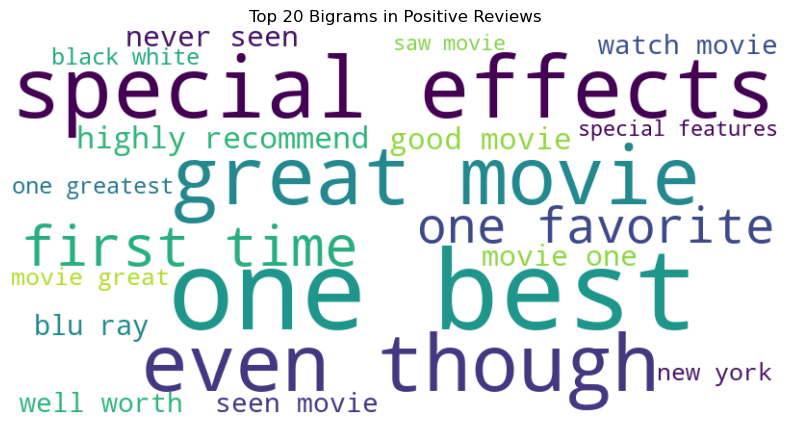

In [35]:
positive_bigrams_dict = {' '.join(bigram): count for bigram, count in top_20_positive_bigrams}
visualize_ngrams(positive_bigrams_dict, 'Top 20 Bigrams in Positive Reviews')

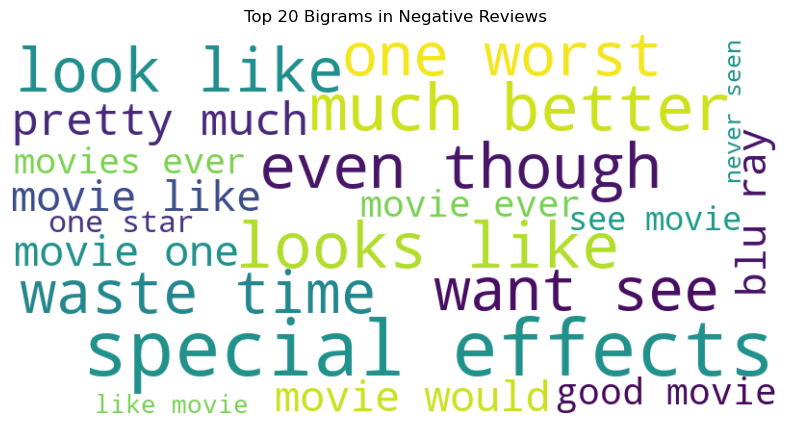

In [36]:
negative_bigrams_dict = {' '.join(bigram): count for bigram, count in top_20_negative_bigrams}
visualize_ngrams(negative_bigrams_dict, 'Top 20 Bigrams in Negative Reviews')

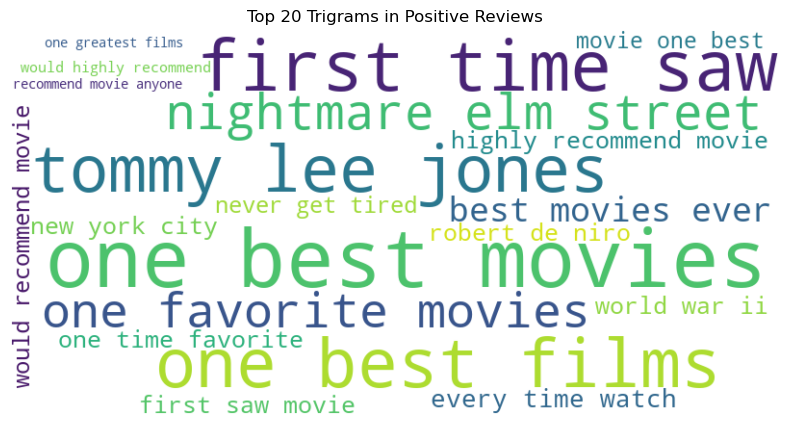

In [37]:
positive_trigrams_dict = {' '.join(trigram): count for trigram, count in top_20_positive_trigrams}
visualize_ngrams(positive_trigrams_dict, 'Top 20 Trigrams in Positive Reviews')

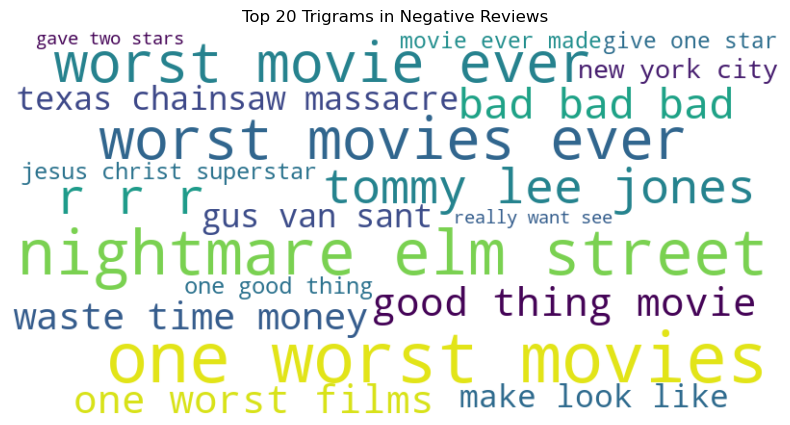

In [38]:
negative_trigrams_dict = {' '.join(trigram): count for trigram, count in top_20_negative_trigrams}
visualize_ngrams(negative_trigrams_dict, 'Top 20 Trigrams in Negative Reviews')

The identified n-grams offer valuable insights into the sentiments expressed in reviews, capturing both positive and negative sentiments. I will be nitpicking ngrams and briefly explaining their purpose.

Best Bigrams:

('one', 'best')
('great', 'movie')
('Highly', 'recommended')
('never', 'seen')
('well', 'worth')
These positive bigrams highlight favorable sentiments, emphasizing terms like "best," "great," and "Highly recommended." They reflect viewers' positive experiences, with mentions of uniqueness ("never seen") and value ("well worth") that I assume are talking about a specific scene or element in a movie. It is easy to distinct a broad review and a specific with bigrams and trigrams than unigrams.

Worst Bigrams:

('much', 'better')
('one', 'worst')
('one', 'star')
('never', 'seen')
('waste', 'time')
In contrast, negative bigrams point to dissatisfaction, with expressions like "much better" and "waste time." Specific mentions of "worst" and "one star" indicate strongly negative opinions, portraying a clear sense of disappointment. It is a lot harder to detect how specific negative reviews are for bigrams comparted to positive reviews, but it gives better insights than unigrams.

Best Trigrams:

('one', 'best', 'movies')
('first', 'time', 'saw')
('every', 'time', 'watch')
('never', 'get', 'tired')
('would', 'highly', 'recommend')
Positive trigrams do great wonders when helping the reader understand more context about the movie, recommending movies ("one best movies") and expressing enduring enjoyment ("never get tired"). The recurring theme of recommending suggests a high level of satisfaction.

Worst Trigrams:

('one', 'worst', 'movies')
('bad', 'bad', 'bad')
('give', 'one', 'star')
('really', 'want', 'see')
('waste', 'time', 'money')
Negative trigrams show strong negative sentiments, with emphatic expressions like "bad bad bad" and clear indications of disappointment, such as "give one star" and "waste time money." The mention of wanting to see ("really want see") suggests unmet expectations.

In conclusion, the [multi] ngrams provide a concise yet informative overview of viewer sentiments, helping to pinpoint specific aspects that contribute to positive or negative reviews, or help understand the general point of the review without having to actually go through it.

### Exercise 7 (8 marks): 

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words. (You do not need to implement your method.)

**Answer.**

In [39]:
import nltk
from nltk import pos_tag, word_tokenize

def extract_informative_words(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    informative_pairs = []

    for i in range(len(tagged_words) - 1):
        word, pos = tagged_words[i]
        next_word, next_pos = tagged_words[i + 1]

        if pos == 'JJ' and next_pos.startswith('N'):
            informative_pairs.append(f"{word} {next_word}")

    return informative_pairs

The code uses NLTK to identify adjectives followed by nouns in a text, creating informative word pairs. For instance, in the sentence "The captivating storyline led to a surprising twist," the output would be ['captivating storyline', 'surprising twist']. This captures the relationship between adjectives and the subsequent nouns, providing meaningful insights into the descriptive elements of the text.

In [40]:
## Example:

text = "The captivating storyline led to a surprising twist."
result = extract_informative_words(text)
print(result)

['surprising twist']


### Exercise 8 (9 marks): 

Write a function(s) that transforms a document into a list of adjective-noun pairs. 
- For each sentence in the document, find each adjective in the sentence and find the first noun that follows it in the sentence. Combine the adjective with the noun in a string that has the format "adjective noun". 
- For example, the document "That was a good, long movie" should return `["good movie", "long movie"]`. If no nouns appear after an adjective, do not add that adjective to the output list. 
- Demonstrate your function works on the first review in `short_movies_tv` and the sentence "The big black dog scared the red cat."

**Answer.** 

In [41]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag, sent_tokenize

def extract_adj_noun_pairs(document):
    adj_noun_pairs = []
    sentences = sent_tokenize(document)
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged_words = pos_tag(words)       
        for i in range(len(tagged_words) - 1):
            word, pos = tagged_words[i]
            if pos.startswith('JJ'):
                for j in range(i + 1, len(tagged_words)):
                    next_word, next_pos = tagged_words[j]
                    if next_pos.startswith('NN'):  
                        adj_noun_pairs.append(f"{word} {next_word}")
                        break  

    return adj_noun_pairs

first_review = short_movies_tv['reviewText'][0]
second_review = "The big black dog scared the red cat"
pairs_in_first_review = extract_adj_noun_pairs(first_review)
pairs_in_second_review = extract_adj_noun_pairs(second_review)
print(pairs_in_first_review)
print(pairs_in_second_review)

['charming version', 'classic Dicken', 'good showing', 'better average']
['big dog', 'black dog', 'red cat']
